# Investigating the Scala Language Open Source Project

This is a second and bigger project that will showcase exploratory data analysis (EDA) with tools of Data Science with Python.

The main objective of this work is to get some data ready for an EDA and to provide insights from it.

There is no unique research question here. I need to explore an open source project I would like to contribute in: the Scala open source project.

Scala is a mature programming language. 

It is a general-purpose programming language that has recently become another prominent language for data scientists. That's why I am curious about its development.

As an open source project, it has the advantage that its entire development history -- who made changes, what was changed, code reviews, etc. -- is publicly available.

I am therefore going to read in, clean up, and visualize the real world project repository of Scala.

Data come from a version control system (Git) as well as a project hosting site (GitHub). 

I will try to visualize the evolution of the project and to find out who has had the most influence on its development and who are the experts of a particular file.

The dataset I will use, which has been previously mined and extracted from GitHub, is comprised of three files:

* <code>pulls_2011-2013.csv</code> contains the basic information about the pull requests, and spans from the end of 2011 up to (but not including) 2014.
* <code>pulls_2014-2018.csv</code> contains identical information, and spans from 2014 up to 2018.
* <code>pull_files.csv</code> contains the files that were modified by each pull request.


Let's get started!

## Preparing and cleaning the data

Let's first load each of the three data files.

In [48]:
# Importing pandas
import pandas as pd

# Loading in the data
pulls_one = pd.read_csv('pulls_2011-2013.csv')
pulls_two = pd.read_csv('pulls_2014-2018.csv')
pull_files = pd.read_csv('pull_files.csv')

Second, I need to combine the data from the two separate pull DataFrames.

In [49]:
# Append pulls_one to pulls_two
pulls = pd.concat([pulls_one, pulls_two])

What info contains the pulls DataFrame?

In [50]:
# Get the DataFrame's info
pulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 2903
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pid     6200 non-null   int64 
 1   user    6200 non-null   object
 2   date    6200 non-null   object
dtypes: int64(1), object(2)
memory usage: 193.8+ KB


The raw data extracted from GitHub contains dates in the ISO8601 format. However, <code>pandas</code> imported them as regular strings. I need therefore to convert the strings into Python's <code>DateTime</code> objects. The pull request times are all in UTC (also known as Coordinated Universal Time). The commit times, however, are in the local time of the author with time zone information (number of hours difference from UTC). To make comparisons easy, we should convert all times to UTC.

In [51]:
# Convert the date for the pulls object
pulls['date'] = pd.to_datetime(pulls['date'], utc=True)

The data extracted comes in two separate files. Merging the two DataFrames will make it easier for me to analyze the data.

In [52]:
# Merge the two DataFrames
data = pd.merge(pulls, pull_files, on='pid')

Let's check the result!

In [53]:
data.head()

,pid,user,date,file
0,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/api/Printers.scala
1,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/internal/Printers.scala
2,11166973,VladimirNik,2013-12-31 23:10:55+00:00,test/files/run/reify_ann3.check
3,11166973,VladimirNik,2013-12-31 23:10:55+00:00,test/junit/scala/reflect/internal/PrintersTest...
4,11161892,Ichoran,2013-12-31 16:55:47+00:00,src/library/scala/collection/mutable/ArrayOps....


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85588 entries, 0 to 85587
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   pid     85588 non-null  int64              
 1   user    85588 non-null  object             
 2   date    85588 non-null  datetime64[ns, UTC]
 3   file    85588 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 3.3+ MB


I am now ready for doing some EDA.

## The pull requests activity of the Scala language

The activity in an open source project is not very consistent. Some projects might be active for many years after the initial release, while others can slowly taper out into oblivion. 

Before committing to contributing to a project, it is important to understand the state of the project. Is development going steadily, or is there a drop? Has the project been abandoned altogether?

These Scala data was collected in January of 2018. I am therefore interested in the evolution of the number of contributions up to that date.

I will do this by plotting a chart of the project's activity. 

I will calculate the number of pull requests submitted each (calendar) month during the project's lifetime. 

I will then plot these numbers to see the trend of contributions twice : first as a barplot, second as a timeseries.

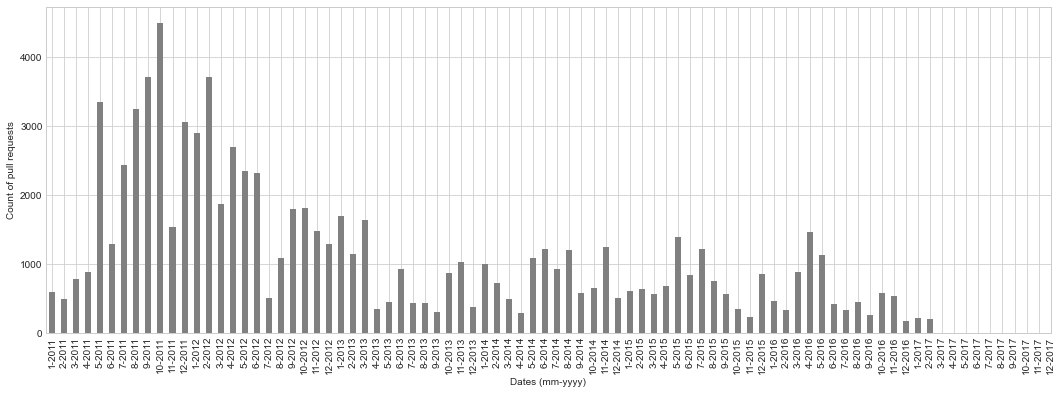

In [110]:
# Importing Matplotlib
import matplotlib.pyplot as plt

# Create a column that will store the month
data['month'] = data['date'].dt.month

# Create a column that will store the year
data['year'] = data['date'].dt.year

# Group by the month and year and count the pull requests
counts = data.groupby(by=['month', 'year']).count()

# Sort the counts by the month and year
counts = counts.sort_values(by=['year', 'month'])

# Create readable xticks labels
xticks_labels = [str(m)+'-'+str(y) for y in range(2011,2018) for m in range(1,13)]

# Plot the results
plt.style.use('seaborn-pastel')
_ = counts.plot(kind='bar', color='grey', figsize = (18,6), rot=90)
_.set_xticks(range(len(xticks_labels)))
_.set_xticklabels(xticks_labels, rotation=90)
_.legend()
_.set_xlabel('Dates (mm-yyyy)')
_.set_ylabel('Count of pull requests')
_.get_legend().remove()

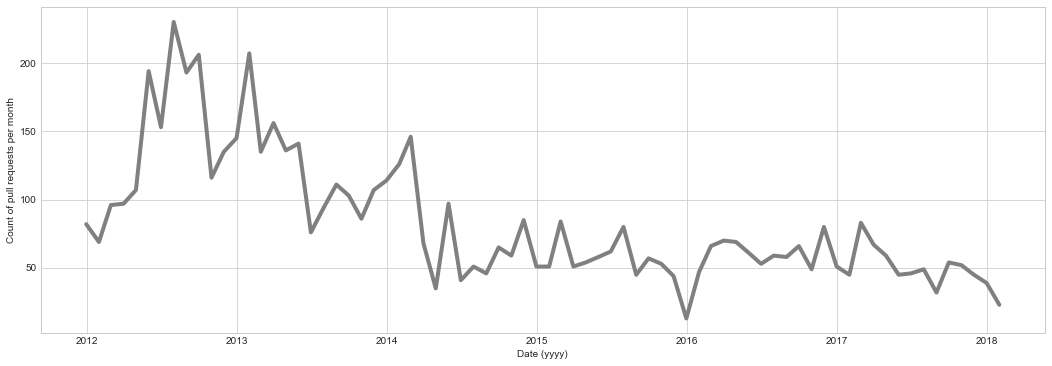

In [111]:
# Importing Seaborn
import seaborn as sns


# Group by the date and count the pull requests
by_dates = data.groupby('date').count()

# Group by the month and count the pull requests
by_months = by_dates.resample('M', convention='end').agg('count')

# Plot the time series of monthly pull requests
plt.figure(figsize=(18, 6))
_ = sns.lineplot(x=by_months.index, y='pid', data=by_months, color='grey', linewidth=4)
_.set_xlabel('Date (yyyy)')
_.set_ylabel('Count of pull requests per month')
plt.show()

Well, these two visualizations tells the same story:

The activity of the Scala language had more than 100 monthly contributions during two years, from 2012 to 2014.

However, there is a drop in the activity in the beginning of 2014.

Unfortunately, this might mean the project is in decline during latest years. But it is not.

Looking closer at the time series, we can also see that this activity is steady from 2014 to 2018.

In 'average', a nearly 50 monthly contributions is observed. Somewhat interesting!

## Is the project really open?

The organizational structure varies from one project to another, and it can influence my success as a contributor. A project that has a very small community might not be the best one to start working on. 

A small community might indicate a high barrier of entry. This can be caused by several factors, including a community that is reluctant to accept pull requests from "outsiders," that the code base is hard to work with, etc.

However, a large community can serve as an indicator that the project is regularly accepting pull requests from new contributors. Such a project would be a good place to start.


In order to evaluate the dynamics of the community, I will plot a histogram of the number of pull requests submitted by each user. 

A distribution that shows that there are few people that only contribute a small number of pull requests can be used as in indicator that the project is not welcoming of new contributors.

What about the Scala project?

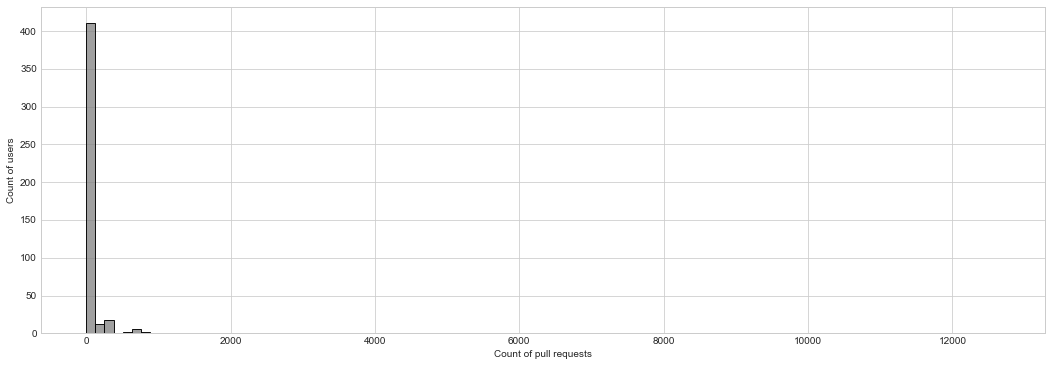

In [106]:
# Group by the submitter
by_user = data.groupby(by='user')['pid'].count()

# Plot the histogram
plt.figure(figsize=(18, 6))
_ = sns.histplot(by_user, kde=False, color='grey', bins=100)
_.set_xlabel('Count of pull requests')
_.set_ylabel('Count of users')
plt.show()

It seems most of users are small contributors. 

Let's have a closer look at the smallest activities. How many users contributes less than 25 pull requests in the project?

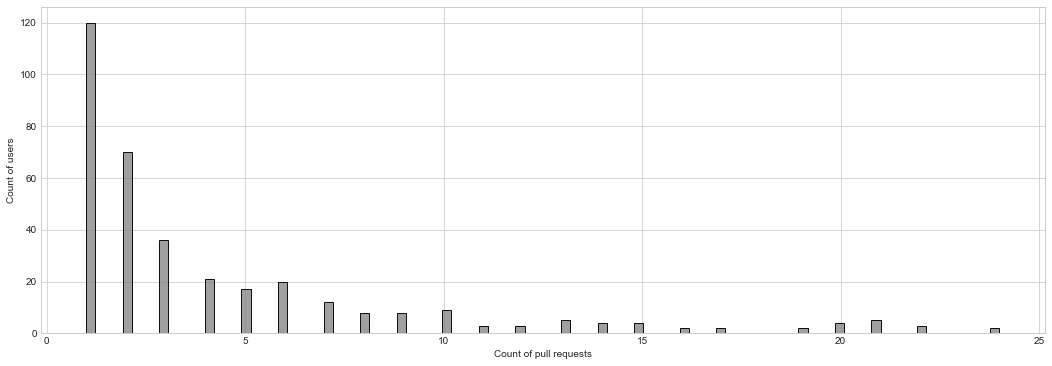

In [107]:
# Restrict users to less than 25 contributions
by_user_restricted = by_user[by_user < 25]

# Plot the histogram
plt.figure(figsize=(18, 6))
_ = sns.histplot(by_user_restricted, kde=False, color='grey', bins=100)
_.set_xlabel('Count of pull requests')
_.set_ylabel('Count of users')
plt.show()

I see 120 users have contributed only once in the project. This seems to be an open and welcoming community. Great!

Wait, what will an ECDF plot tell me? Let me plot it.

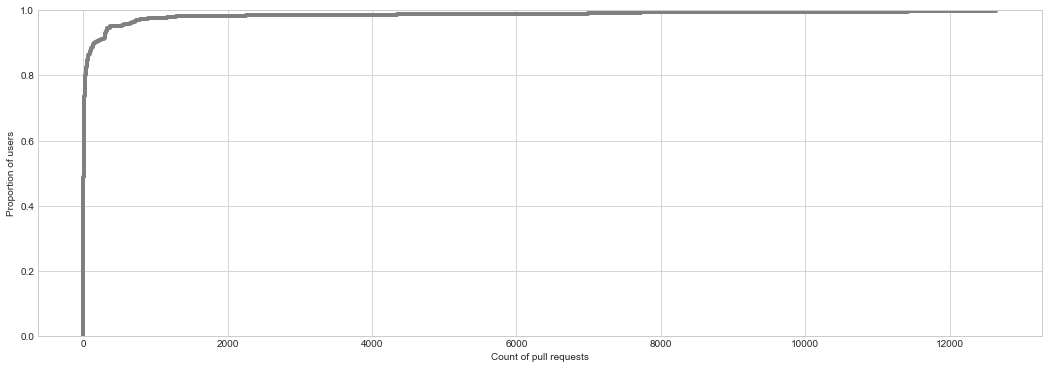

In [108]:
# Plot the ecdf
plt.figure(figsize=(18, 6))
_ = sns.ecdfplot(by_user, color='grey', linewidth=4)
_.set_xlabel('Count of pull requests')
_.set_ylabel('Proportion of users')
plt.show()

Again, let's quick check the least pull requests!

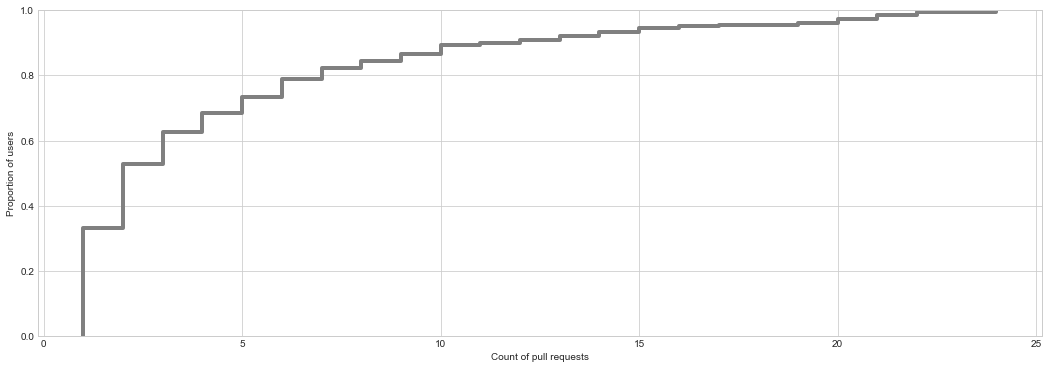

In [109]:
# Plot the ecdf
plt.figure(figsize=(18, 6))
_ = sns.ecdfplot(by_user_restricted, color='grey', linewidth=4)
_.set_xlabel('Count of pull requests')
_.set_ylabel('Proportion of users')
plt.show()

These two plots confirm our observation with the histograms: most of the Scala project contributors are small contributors.

## What files might not be the most effective use of my time?

Choosing the right place to make a contribution is as important as choosing the project to contribute to. 

Some parts of the code might be stable, some might be dead. Contributing there might not have the most impact. 

Therefore it is important to understand the parts of the system that have been recently changed. This allows me to pinpoint the "hot" areas of the code where most of the activity is happening. 

Focusing on those parts might not be the most effective use of my time.

What are the files concerned with the 10 most recent pull requests?

In [78]:
# Identify the last 10 pull requests
last_10 = pulls.nlargest(10, columns='date')

# Join the two data sets
joined_pr = last_10.merge(pull_files, on='pid')

# Identify the unique files
files = set(joined_pr['file'].unique())

# Print the results
files

{'LICENSE',
 'doc/LICENSE.md',
 'doc/License.rtf',
 'project/VersionUtil.scala',
 'src/compiler/scala/reflect/reify/phases/Calculate.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/PostProcessor.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/analysis/BackendUtils.scala',
 'src/compiler/scala/tools/nsc/profile/AsyncHelper.scala',
 'src/compiler/scala/tools/nsc/profile/Profiler.scala',
 'src/compiler/scala/tools/nsc/symtab/classfile/ClassfileParser.scala',
 'src/compiler/scala/tools/nsc/typechecker/Contexts.scala',
 'src/library/scala/Predef.scala',
 'src/library/scala/concurrent/Lock.scala',
 'src/library/scala/util/Properties.scala',
 'src/reflect/scala/reflect/internal/pickling/ByteCodecs.scala',
 'src/reflect/scala/reflect/internal/tpe/GlbLubs.scala',
 'src/scaladoc/scala/tools/nsc/doc/html/page/Entity.scala',
 'src/scalap/decoder.properties',
 'test/files/neg/leibniz-liskov.check',
 'test/files/neg/leibniz-liskov

These files were on the most recent active development up to date.

I am interested in one specific file: <code>src/compiler/scala/reflect/reify/phases/Calculate.scala</code>. But wait.

## Who could help me the most?

When contributing to that project, I might need some guidance. 
    
I might find myselves needing some information regarding the file I choose.
    
Contributors to open source projects generally have other day jobs, so their time is limited. It is important to address my questions to the right people. 
    
One way to identify the right target for my inquiries is by using their contribution history.

I am interested in the top 3 developers who changed that file <code>Calculate.scala</code>. 

Those developers are the ones most likely to have the best understanding of the code.

In [97]:
# This is the file I am interested in:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Identify the commits that changed the file
file_pr = data[data['file']==file]

# Count the number of changes made by each developer
author_counts = file_pr.groupby(by='user').count()

# Print the top 3 developers
author_counts.nlargest(3, columns='pid')

,pid,date,file,month,year
user,,,,,
xeno-by,11,11,11,11,11
retronym,5,5,5,5,5
soc,4,4,4,4,4


I know now who has the best understanding of the code from that file. 

I could have a look for another file and their best contributors with my last work, but do these users still work on the file?

## Who is still working on a file I am interested in?

Open source projects suffer from fluctuating membership. This makes the problem of finding the right person more challenging: the person has to be knowledgeable **and** still be involved in the project. 
    
A person that contributed a lot in the past might no longer be available (or willing) to help. 
    
To get a better understanding, I need to investigate the more recent history of that particular part of the system.
    
Like in the previous work, I will look at the history of  <code>src/compiler/scala/reflect/reify/phases/Calculate.scala</code>.

In [80]:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Select the pull requests that changed the target file
file_pr = data[data['file']==file]

# Merge the obtained results with the pulls DataFrame
joined_pr = file_pr.merge(pulls, on='pid')

# Find the users of the last 10 most recent pull requests
users_last_10 = set(joined_pr.nlargest(10, columns=['date_y'])['user_x'])

# Printing the results
users_last_10

{'bjornregnell', 'retronym', 'soc', 'starblood', 'xeno-by', 'zuvizudar'}

I see that fortunately the three users, <code>xeno-by</code>, <code>retronym</code> and <code>soc</code> that know the file the best are still working on. Let's check their activity and find out who might I contact!

## The pull requests of three special developers

Now that I have identified three potential contacts in the project, I need to find the person who was most involved in the project in recent times.

That person is most likely to answer my questions. 

For each calendar year, I am therefore interested in understanding the number of pull requests the authors submitted. 

This will give me a high-level image of their contribution trend to the project and help me to identify who is likely to help me the most.

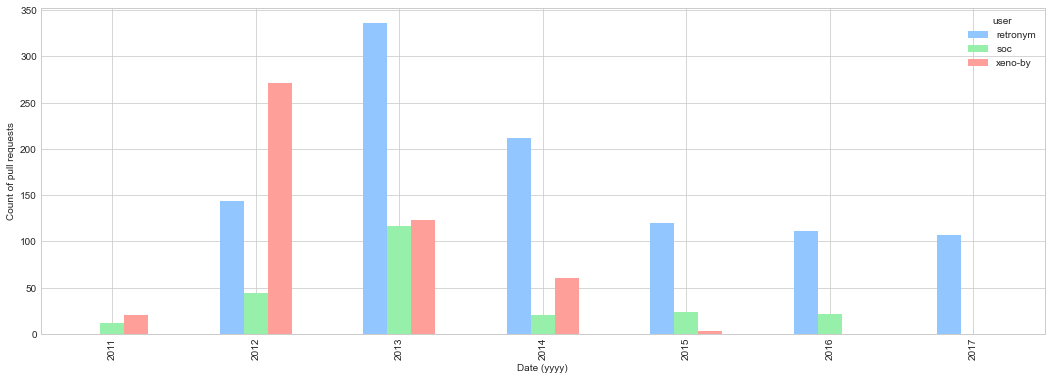

In [103]:
# The developers we are interested in
authors = ['xeno-by', 'retronym', 'soc']

# Get all the developers' pull requests
by_author = pulls[pulls['user'].isin(authors)]

# Count the number of pull requests submitted each year
counts = by_author.groupby(['user', by_author['date'].dt.year]).agg({'pid': 'count'}).reset_index()

# Convert the table to a wide format
counts_wide = counts.pivot_table(index='date', columns='user', values='pid', fill_value=0)

# Plot the results
_ = counts_wide.plot(kind='bar', figsize = (18,6))
_.set_xlabel('Date (yyyy)')
_.set_ylabel('Count of pull requests')
plt.show()

That's <code>retronym</code> who could help me in the Scala project! Really? But how much experience has he in the file I am intested in ?

## Visualizing the contributions of each developer in <code>Calculate.scala</code>
As mentioned before, it is important to make a distinction between the global expertise and contribution levels and the contribution levels at a more granular level (file, submodule, etc.) 

In my case, I want to see which of our three developers of interest have the most experience with the code in a given file. 

I will measure experience by the number of pull requests submitted that affect that file and how recent those pull requests were submitted.

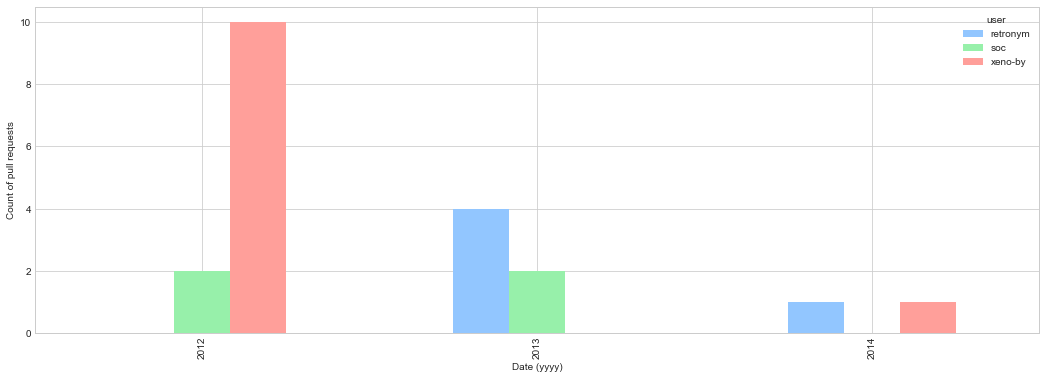

In [112]:
authors = ['xeno-by', 'retronym', 'soc']
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Select the pull requests submitted by the authors, from the `data` DataFrame
by_author = data[data['user'].isin(authors)]

# Select the pull requests that affect the file
by_file = by_author[by_author['file']==file]

# Group and count the number of PRs done by each user each year
grouped = by_file.groupby(['user', by_file['date'].dt.year]).count()['pid'].reset_index()

# Transform the data into a wide format
by_file_wide = grouped.pivot_table(index='date', columns='user', values='pid', fill_value=0)


# Plot the results
_ = by_file_wide.plot(kind='bar', figsize = (18,6))
_.set_xlabel('Date (yyyy)')
_.set_ylabel('Count of pull requests')
plt.show()

Nice, I can now compare through visualization the experience of the three top contributors of the file. I can do my analysis.

I can see <code>xeno-by</code> has most pull requests in total. Then <code>retronym</code> and <code>soc</code>.

However, contributions have been done in the beginning of the Scala project! 

The most recent active contributor in the overall project is <code>retronym</code>. It happens he is the second top contributor in the file of my interest. 

He is the best match of my research! 

The Scala project is steadily still active and a welcoming open source community to work with.

I found out the most recent files under development and I found out likely the most active and experienced user that could help in pa specific file. Nice job!